In [119]:
# Installing Necessary Packages on Colab #

%pip install dask-ms[xarray]
%pip install astropy
%pip install sgp4

In [168]:
# Importing Packages #

import dask.array as da
from daskms import xds_from_table, xds_to_table
from dask.distributed import Client

import numpy as np

from astropy import units as u
from astropy.time import Time

import matplotlib.pylab as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
          'font.size':13,
         'figure.max_open_warning': 0}

plt.rcParams.update(params)
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import scipy.stats as stat
from scipy.optimize import curve_fit, minimize_scalar
from scipy.signal import detrend, convolve
import math

from sgp4.api import Satrec
from sgp4.api import SGP4_ERRORS
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation, ITRS, angular_separation, EarthLocation, AltAz, SkyCoord

In [169]:
# Mounting Google Drive to Access the File #

from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/ColabNotebooks/'
ds = xds_from_table(data_path+"1548939342.ms")
tlefile = data_path+"requested_TLE.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory data analysis (EDA)

In [170]:
# Getting the observation data

obs_table = xds_from_table(data_path+"1548939342.ms::OBSERVATION")
print(obs_table)

[<xarray.Dataset> Size: 81B
Dimensions:         (row: 1, log: 1, schedule: 1, obs-exts: 2)
Coordinates:
    ROWID           (row) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: row, log, schedule, obs-exts
Data variables:
    LOG             (row, log) object 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
    SCHEDULE        (row, schedule) object 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
    SCHEDULE_TYPE   (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    TELESCOPE_NAME  (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    OBSERVER        (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    TIME_RANGE      (row, obs-exts) float64 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    PROJECT         (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    RELEASE_DATE    (row) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    FLAG_ROW        (row) bool 1B dask.array<chunksize=(1,), meta=

In [171]:
# Question 1 - Start and End of Observation

time_range = obs_table[0]["TIME_RANGE"].values

start = time_range[0][0]/(60*60*24)
end = time_range[0][1]/(60*60*24)

start = Time(start, format='mjd', scale='utc')
end = Time(end, format='mjd', scale='utc')
start_mjd = start.iso
end_mjd = end.iso

print("The start of the observation:",start_mjd)
print("The end of the observation:",end_mjd)

The start of the observation: 2019-01-31 12:56:12.123
The end of the observation: 2019-01-31 12:59:48.031


In [172]:
# Question 2 - Name of Source

source_table = xds_from_table(data_path+"1548939342.ms::SOURCE")
name = (source_table[0]["NAME"].values)[0]
print("The name of the source is:", name)

The name of the source is: PKS1934-63


In [173]:
# Questions 3 and 4 - Extracting Data from the Spectral Table

spectral_table = xds_from_table(data_path+"1548939342.ms::SPECTRAL_WINDOW")

frequencies = spectral_table[0]['CHAN_FREQ'].values
nchannels = spectral_table[0]['NUM_CHAN'].values[0]
channel_width = spectral_table[0]['CHAN_WIDTH'].values[0][0]
bandwidth = spectral_table[0]['TOTAL_BANDWIDTH'].values[0]

print(f"Frequency range (MHz): {frequencies.min()/1e6} - {frequencies.max()/1e6}")
print(f"Total number of channels {nchannels}")
print(f"Channel width (kHz): {channel_width/1e3}")
print(f"Total Bandwidth (MHz): {bandwidth/1e6}")

Frequency range (MHz): 856.0 - 1711.1640625
Total number of channels 1024
Channel width (kHz): 835.9375
Total Bandwidth (MHz): 856.0


In [174]:
# Question 5 - Number of Antennas Used

A1 = ds[0]["ANTENNA1"]
A2 = ds[0]["ANTENNA2"]
ant_list = list(set(np.append(A1,A2)))
nants = len(ant_list)
print(f'Total number of antennas used {nants}')

Total number of antennas used 50


# Understanding the UVW

Text(0.5, 1.0, 'UV Coverage Plot')

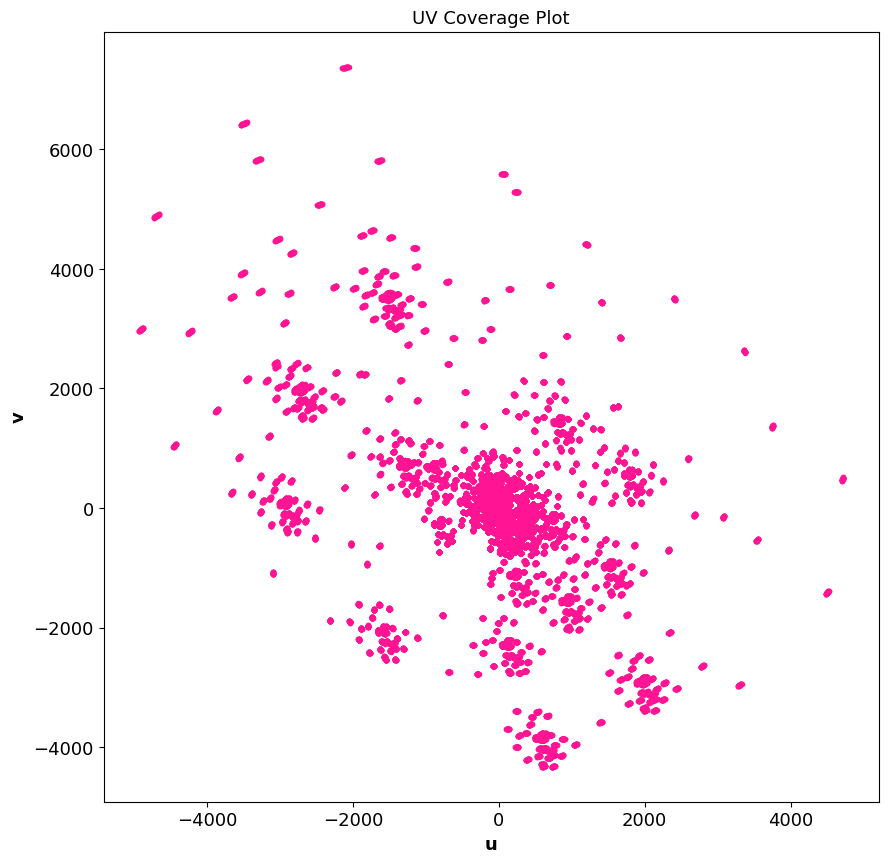

In [175]:
# Question 1 - Plotting the UV Coverage

u,v,w = ds[0]['UVW'][:,0],ds[0]['UVW'][:,1],ds[0]['UVW'][:,2]

fig, axs = plt.subplots(1,1,figsize=[10,10])

plt.plot(u,v,'.', color='deeppink')

plt.xlabel('u')
plt.ylabel('v')
plt.title("UV Coverage Plot")

In [176]:
# Reading in the Antenna Table

antenna_table = xds_from_table(data_path+"1548939342.ms::ANTENNA")
antenna_names = np.array(antenna_table[0]['NAME'].values)
antenna_positions = antenna_table[0]['POSITION'].values

In [177]:
# Question 2 - Finding the Longest and Shortest Baselines

X,Y,Z = antenna_table[0]['POSITION'][:,0],antenna_table[0]['POSITION'][:,1],antenna_table[0]['POSITION'][:,2]

X = np.array(X)
Y = np.array(Y)

def euclidean_dist(X1, Y1, X2, Y2):
  return np.sqrt((X1 - X2)**2 + (Y1 - Y2)**2)

# Finding the max distance

max_distance = 0
antenna1_name = ''
antenna2_name = ''

for i in range(len(antenna_names)):
  for j in range(i + 1, len(antenna_names)):
    dist = euclidean_dist(X[i], Y[i], X[j], Y[j])

    if dist > max_distance:
      max_distance = dist
      antenna1_name = antenna_names[i]
      antenna2_name = antenna_names[j]

print(f'The maximum distance between antennas is {max_distance} between {antenna1_name} and {antenna2_name}')

# Finding the min distance

min_distance = float('inf')  # Initialize with infinity
antenna1_name = ''
antenna2_name = ''

for i in range(len(antenna_names)):
  for j in range(i + 1, len(antenna_names)):
    dist = euclidean_dist(X[i], Y[i], X[j], Y[j])

    if dist < min_distance:
      min_distance = dist
      antenna1_name = antenna_names[i]
      antenna2_name = antenna_names[j]

print(f'The minimum distance between antennas is {min_distance} between {antenna1_name} and {antenna2_name}')

The maximum distance between antennas is 7294.423298982904 between m049 and m059
The minimum distance between antennas is 20.33152654948573 between m000 and m001


In [178]:
# Question 3 - Expected Resolution

c = 3*10**8   #m/s
central_wavelength = c/(bandwidth/2 + frequencies.min())

def resolution(baseline):
  return central_wavelength/baseline

print(f"The resolution of the maximum baseline is: {resolution(max_distance)} radians")
print(f"The resolution of the minimum baseline is: {resolution(min_distance)} radians")

The resolution of the maximum baseline is: 3.203061437984581e-05 radians
The resolution of the minimum baseline is: 0.011491751947125385 radians


In [179]:
# Question 4 - Delay Applied to Baselines

def delay(baseline):
  return baseline/c

print(f"The maximum baseline delay is:{delay(max_distance)} s")
print(f"The minimum baseline delay is:{delay(min_distance)} s")

The maximum baseline delay is:2.4314744329943016e-05 s
The minimum baseline delay is:6.777175516495243e-08 s


# Radio Frequency Interference (RFI)


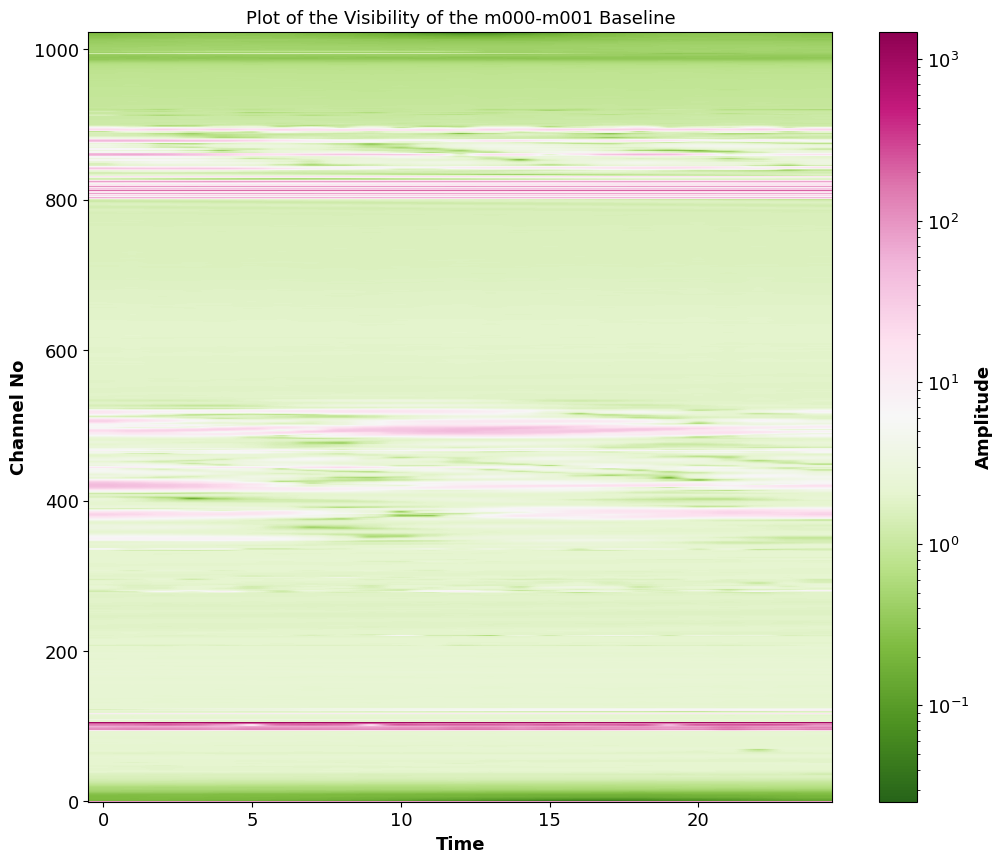

In [180]:
# Choosing the minimum baseline to be our default baseline

a1 = 0
a2 = 1

idx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))

vis = ds[0].DATA.data[idx]

# Plotting the visibility of this baseline

plt.imshow(np.abs(vis[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.title(f"Plot of the Visibility of the m000-m001 Baseline")
plt.colorbar(label='Amplitude')

In [181]:
# Creating a function to convert from channel number to frequency

def channel_to_mhz(channel):
  return (856 + channel * (835.9375/1e3))

Text(0.5, 1.0, 'Plot of the RFI Region from 934.58MHz to 944.61MHz')

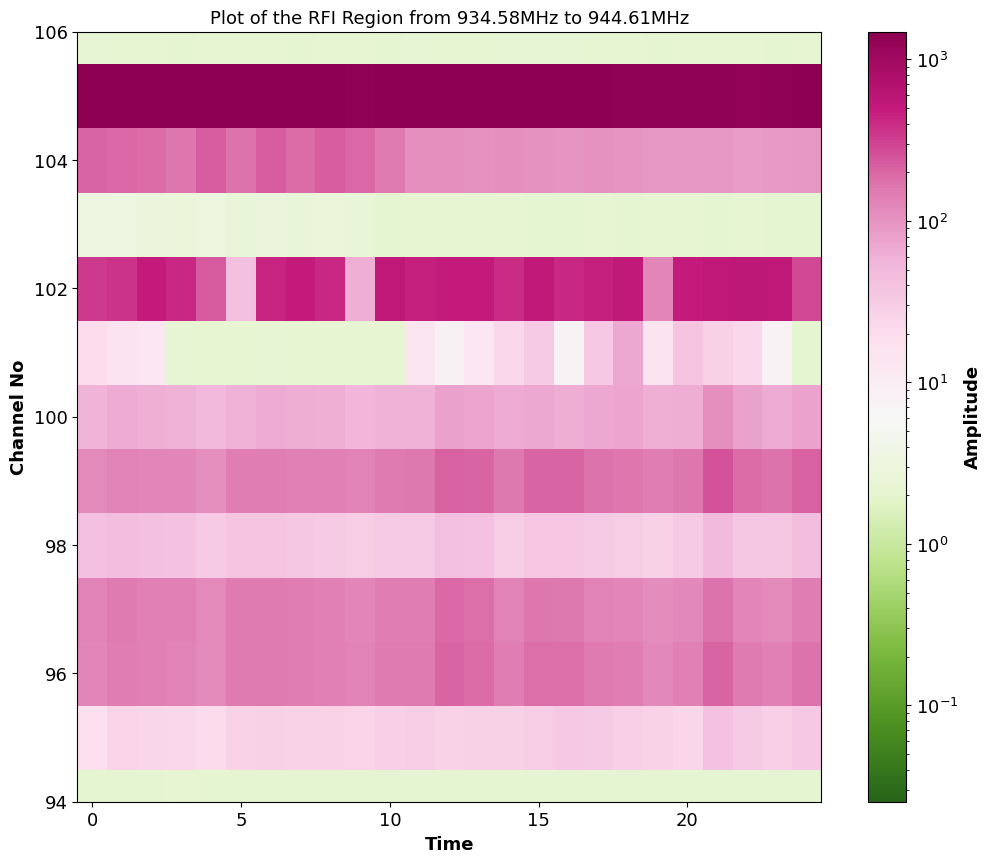

In [182]:
# Question 1 - First RFI Region

plt.imshow(np.abs(vis[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )

plt.ylim(94,106)

plt.colorbar(label='Amplitude')

plt.xlabel('Time')
plt.ylabel('Channel No')

plt.title(f"Plot of the RFI Region from {channel_to_mhz(94):.2f}MHz to {channel_to_mhz(106):.2f}MHz")

Text(0.5, 1.0, 'Plot of the RFI Region from 1131.86MHz to 1299.05MHz')

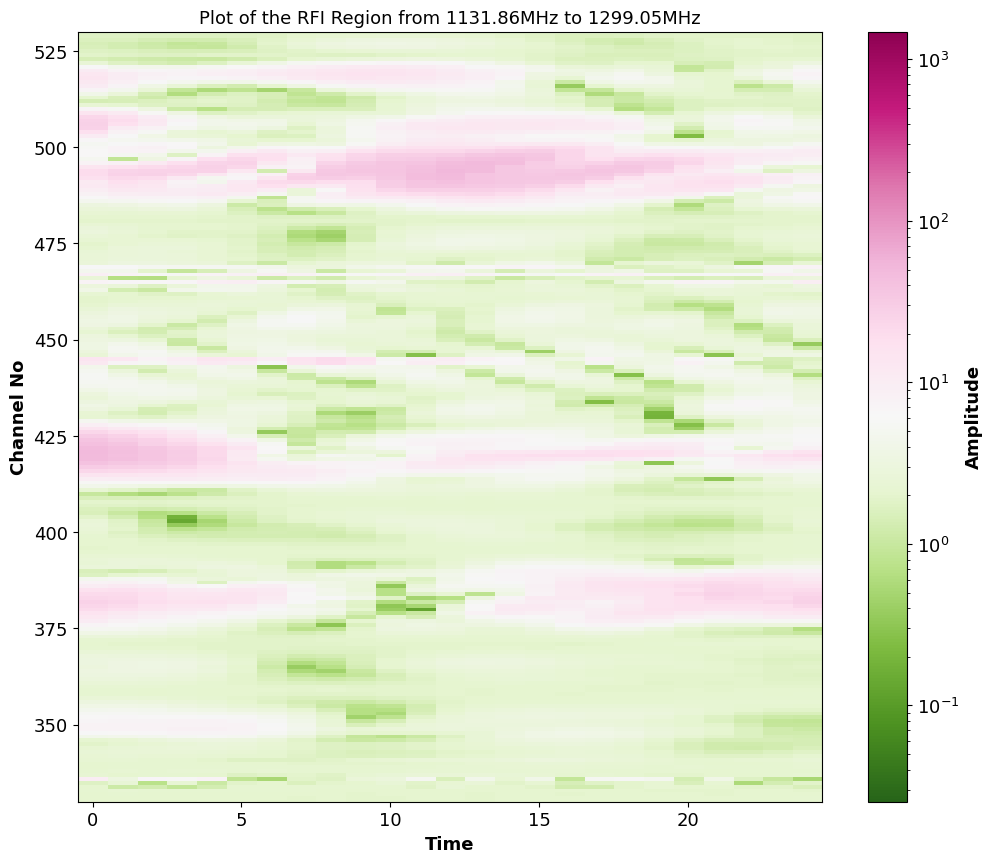

In [183]:
# Question 1 - Second RFI Region

plt.imshow(np.abs(vis[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )

plt.ylim(330,530)

plt.colorbar(label='Amplitude')

plt.xlabel('Time')
plt.ylabel('Channel No')

plt.title(f"Plot of the RFI Region from {channel_to_mhz(330):.2f}MHz to {channel_to_mhz(530):.2f}MHz")

Text(0.5, 1.0, 'Plot of the RFI Region from 1524.75MHz to 1608.34MHz')

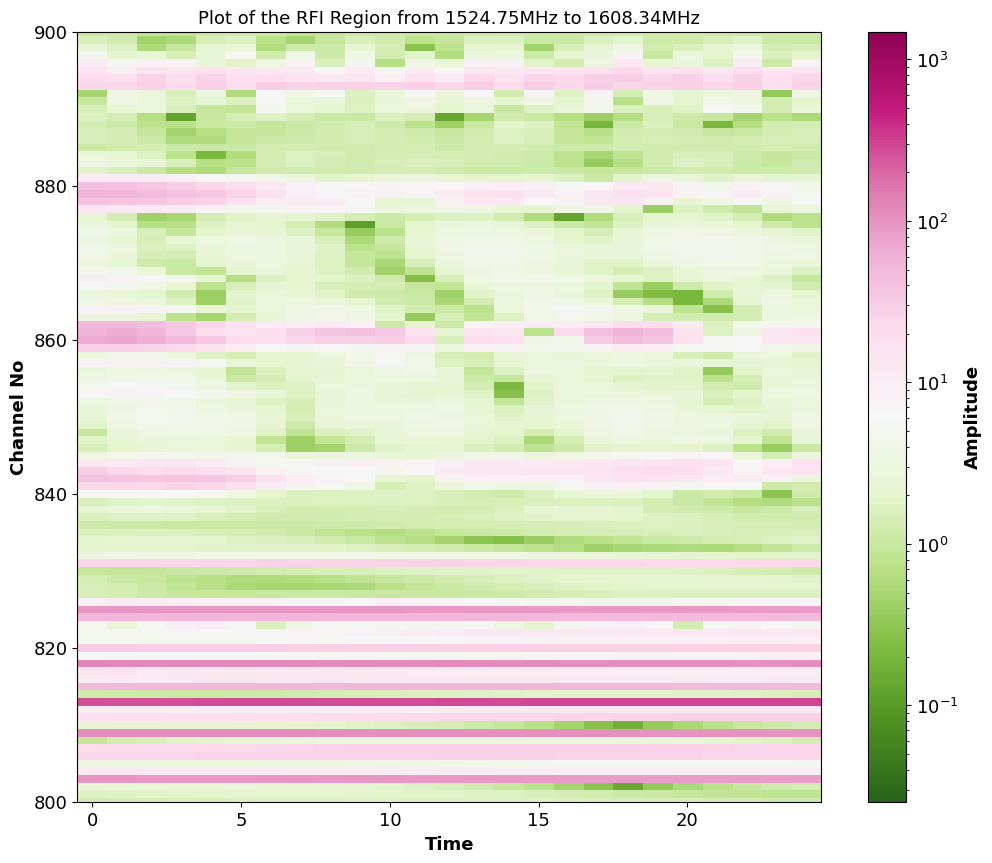

In [184]:
# Question 1 - Third RFI Region

plt.imshow(np.abs(vis[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )

plt.ylim(800,900)

plt.colorbar(label='Amplitude')

plt.xlabel('Time')
plt.ylabel('Channel No')

plt.title(f"Plot of the RFI Region from {channel_to_mhz(800):.2f}MHz to {channel_to_mhz(900):.2f}MHz")

In [185]:
# Question 2 - Histogram Distributions of an RFI and Clean Region

vis_clean = []
vis_rfi = []

for a1 in range(0,10):    # Looping over the short baselines

    for a2 in range(a1,10):   # To not loop over the same pairs twice

      if antenna_table[0].NAME.data[a1].compute() != antenna_table[0].NAME.data[a2].compute():    # Not include autocorrelation

        idx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]

        vis_rfi.append(np.abs(ds[0].DATA.data[idx][:,102,0].compute()))
        vis_clean.append(np.abs(ds[0].DATA.data[idx][:,750,0].compute()))

vis_clean = np.concatenate(vis_clean)
vis_dirty = np.concatenate(vis_rfi)

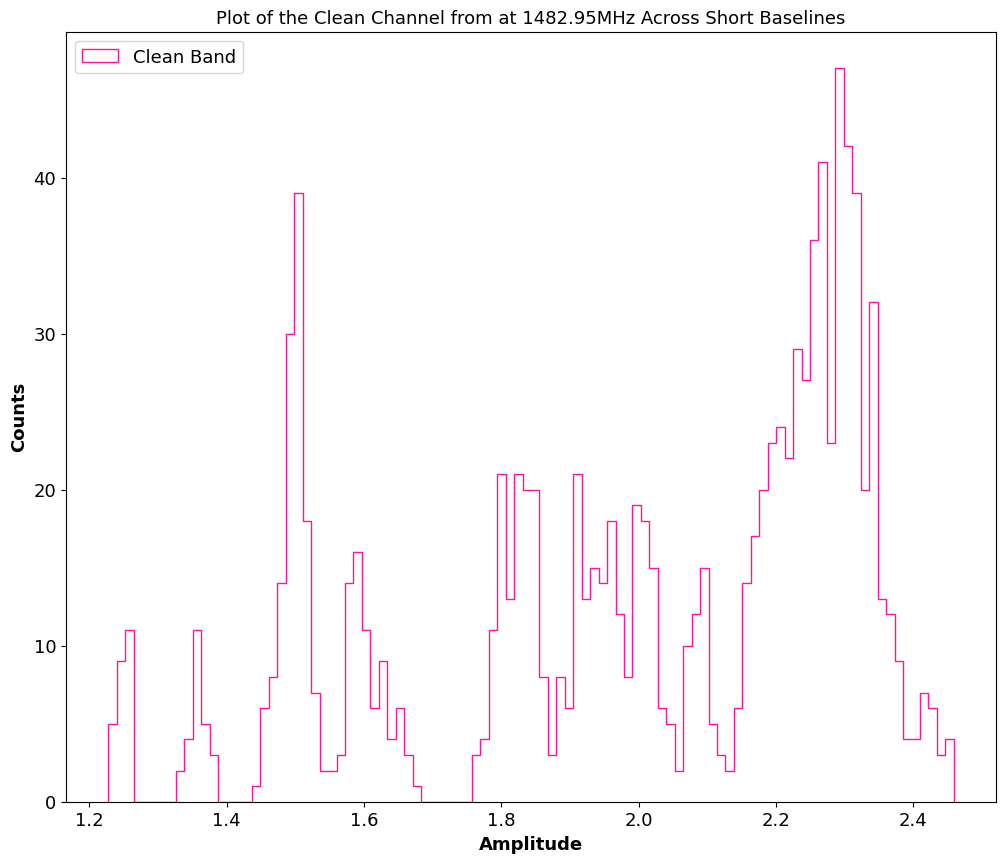

In [186]:
# Plotting the Clean histogram

plt.hist(vis_clean, bins=100, color='deeppink', label='Clean Band', histtype='step')

plt.xlabel('Amplitude')
plt.ylabel('Counts')

plt.title(f"Plot of the Clean Channel from at {channel_to_mhz(750):.2f}MHz Across Short Baselines")
plt.legend()

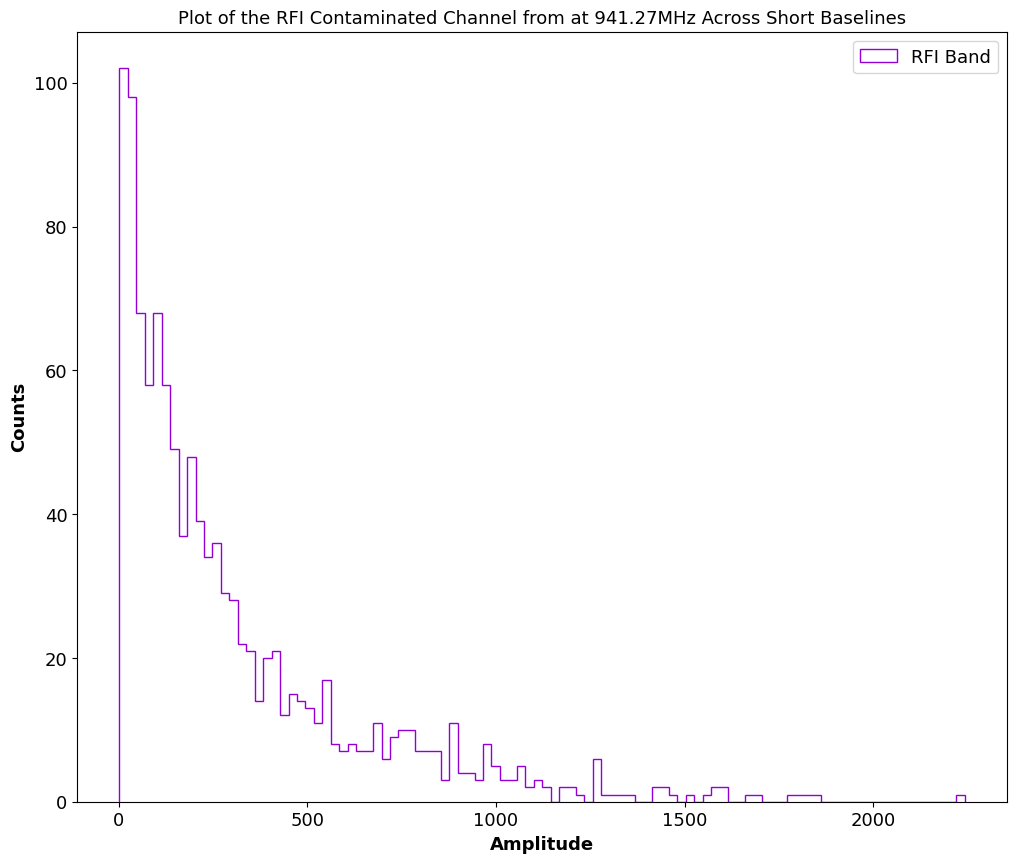

In [187]:
# Plotting the RFI histogram

plt.hist(vis_dirty, bins=100, color='darkviolet', label='RFI Band', histtype='step')

plt.ylabel('Counts')
plt.xlabel('Amplitude')

plt.title(f"Plot of the RFI Contaminated Channel from at {channel_to_mhz(102):.2f}MHz Across Short Baselines")
plt.legend()

In [188]:
# Question 3 - Measure of Spread of the Regions

rfi_spread = np.std(vis_dirty)
print(f"The standard deviation of the RFI is: {rfi_spread}")
clean_spread = np.std(vis_clean)
print(f"The standard deviation of the Clean region is: {clean_spread}")

The standard deviation of the RFI is: 332.27398681640625
The standard deviation of the Clean region is: 0.31923508644104004


In [189]:
# Question 4 - Kurtosis and Skewness of the Regions

rfi_kurt = stat.kurtosis(vis_dirty)
rfi_skew = stat.skew(vis_dirty)
print(f"The kurtosis of the RFI is: {rfi_kurt}")
print(f"The skewness of the RFI is: {rfi_skew}")

clean_kurt = stat.kurtosis(vis_clean)
clean_skew = stat.skew(vis_clean)
print(f"The kurtosis of the Clean region is: {clean_kurt}")
print(f"The skewness of the Clean region is: {clean_skew}")

The kurtosis of the RFI is: 3.9808994729123617
The skewness of the RFI is: 1.8547243404452065
The kurtosis of the Clean region is: -0.7964800320707517
The skewness of the Clean region is: -0.6434408753363252


In [190]:
# Defining a Function that gives the index of a certain antenna

def find_index(antenna_name):
    return np.where(antenna_names == antenna_name)[0][0]

# print(find_index("m048"))
# print(find_index("m060"))

38
47


In [191]:
# Question 5 - Selecting a Long and Short Baseline

a1_short = 0    # Baseline between antenna m000 and m002
a2_short = 2

idx_short = np.where((ds[0].ANTENNA1 == a1_short) & (ds[0].ANTENNA2 == a2_short))

vis_short = ds[0].DATA.data[idx_short]

a1_long = 38    # Baseline between antenna m048 and m060
a2_long = 47

idx_long = np.where((ds[0].ANTENNA1 == a1_long) & (ds[0].ANTENNA2 == a2_long))

vis_long = ds[0].DATA.data[idx_long]

Text(0.5, 1.0, 'Plot of the Visibility of the Short Baseline m000-m002')

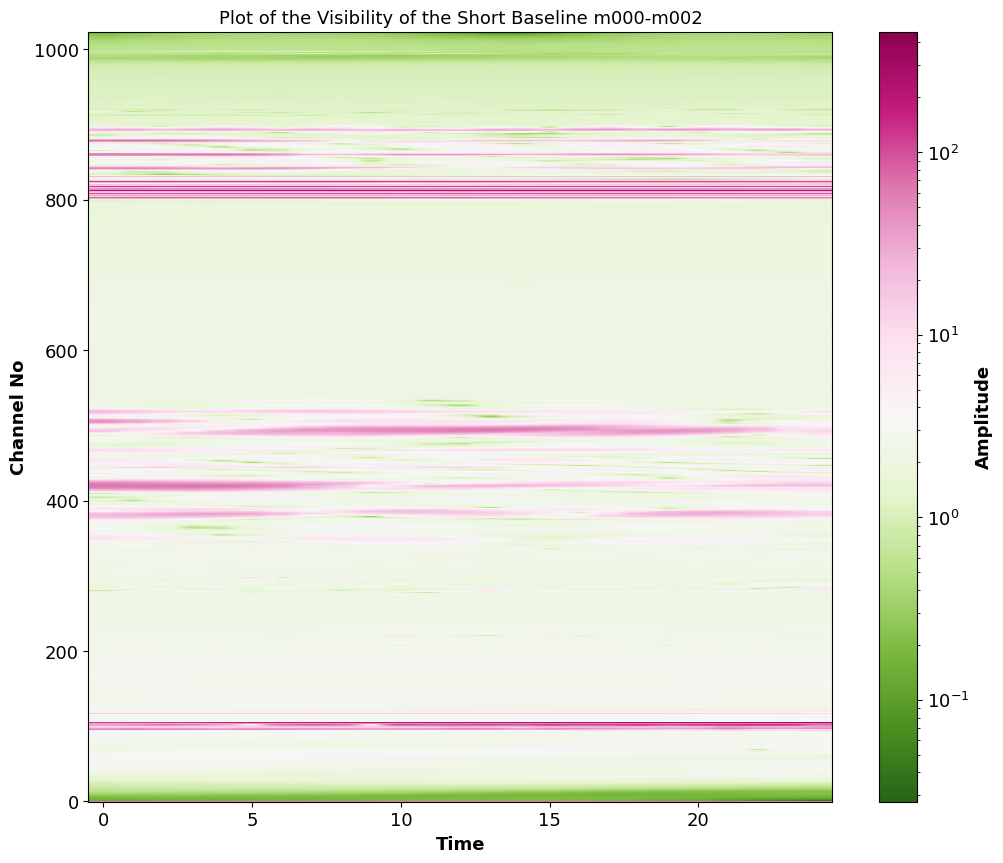

In [192]:
# Plotting the short baseline visibility

plt.imshow(np.abs(vis_short[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )

plt.colorbar(label='Amplitude')

plt.xlabel('Time')
plt.ylabel('Channel No')

plt.title(f"Plot of the Visibility of the Short Baseline m000-m002")

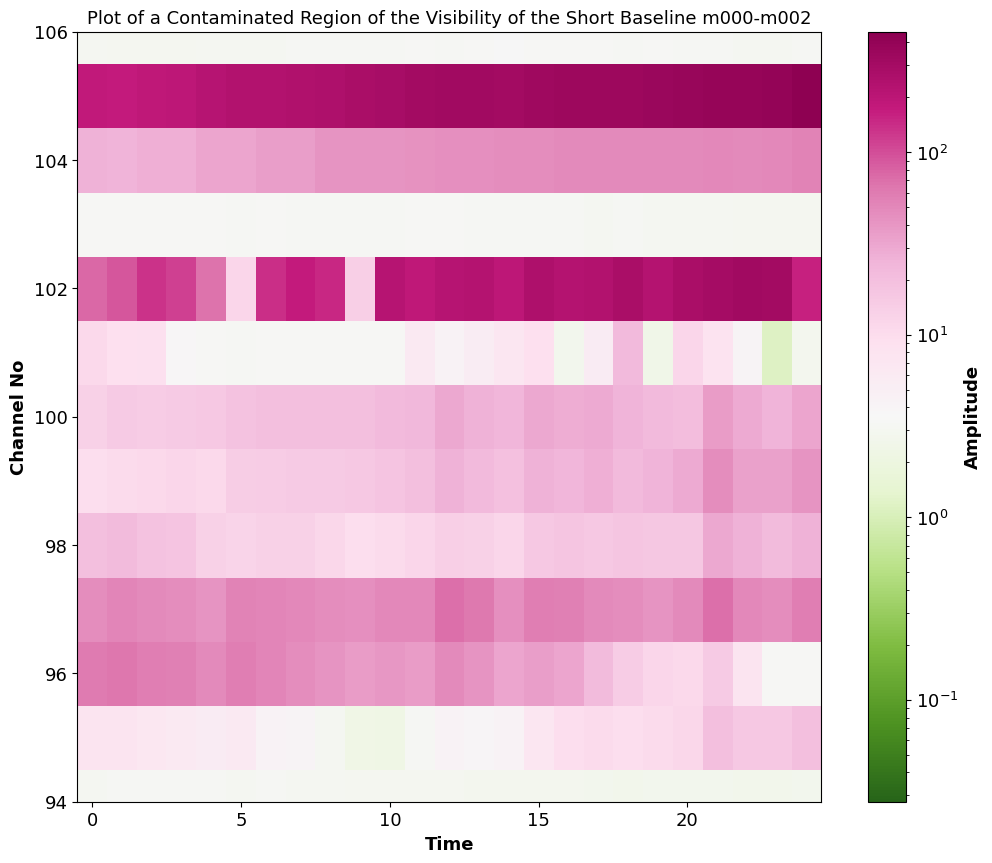

In [193]:
# Plotting the short baseline visibility - zoomed in on RFI region

plt.imshow(np.abs(vis_short[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )

plt.ylim(94,106)

colorbar = plt.colorbar(label='Amplitude')

plt.xlabel('Time')
plt.ylabel('Channel No')

plt.title(f"Plot of a Contaminated Region of the Visibility of the Short Baseline m000-m002")

vlims = [colorbar.vmin, colorbar.vmax]    # Finding the colourbar limits for comparison with the other baseline

Text(0.5, 1.0, 'Plot of the Visibility of the Long Baseline m048-m060')

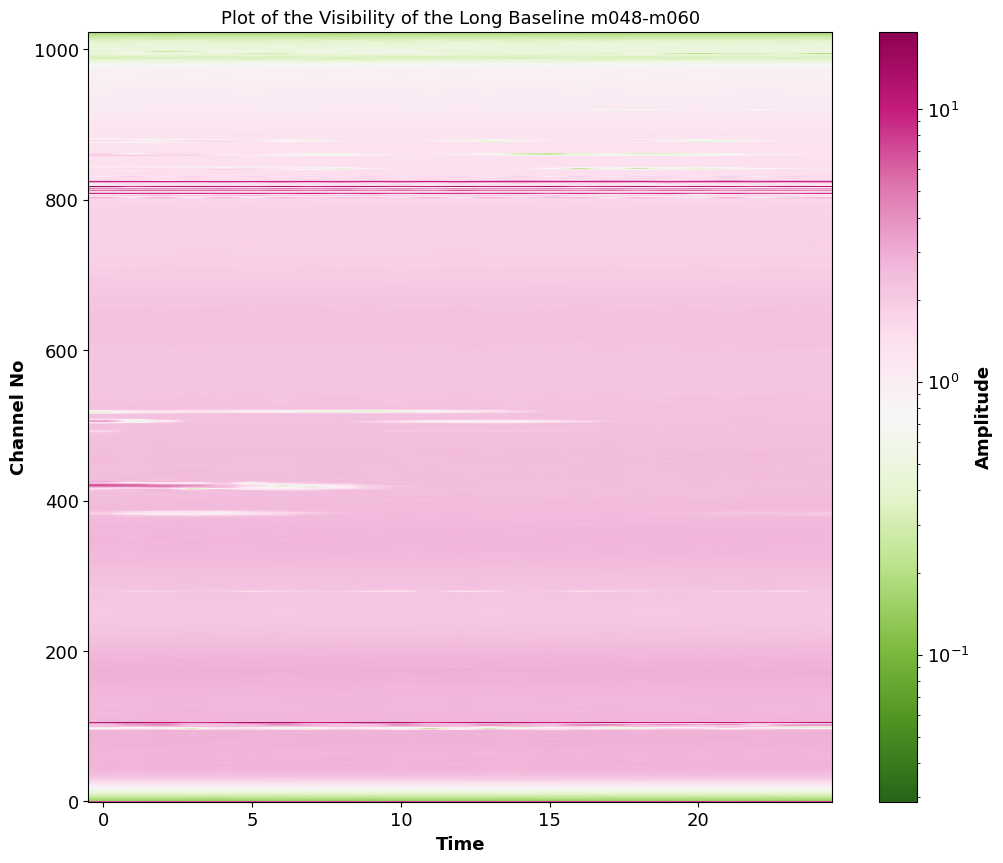

In [194]:
# Plotting the long baseline visibility

plt.imshow(np.abs(vis_long[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )

plt.colorbar(label='Amplitude')

plt.xlabel('Time')
plt.ylabel('Channel No')

plt.title(f"Plot of the Visibility of the Long Baseline m048-m060")

Text(0.5, 1.0, 'Plot of a Contaminated Region of the Visibility of the Long Baseline m048-m060')

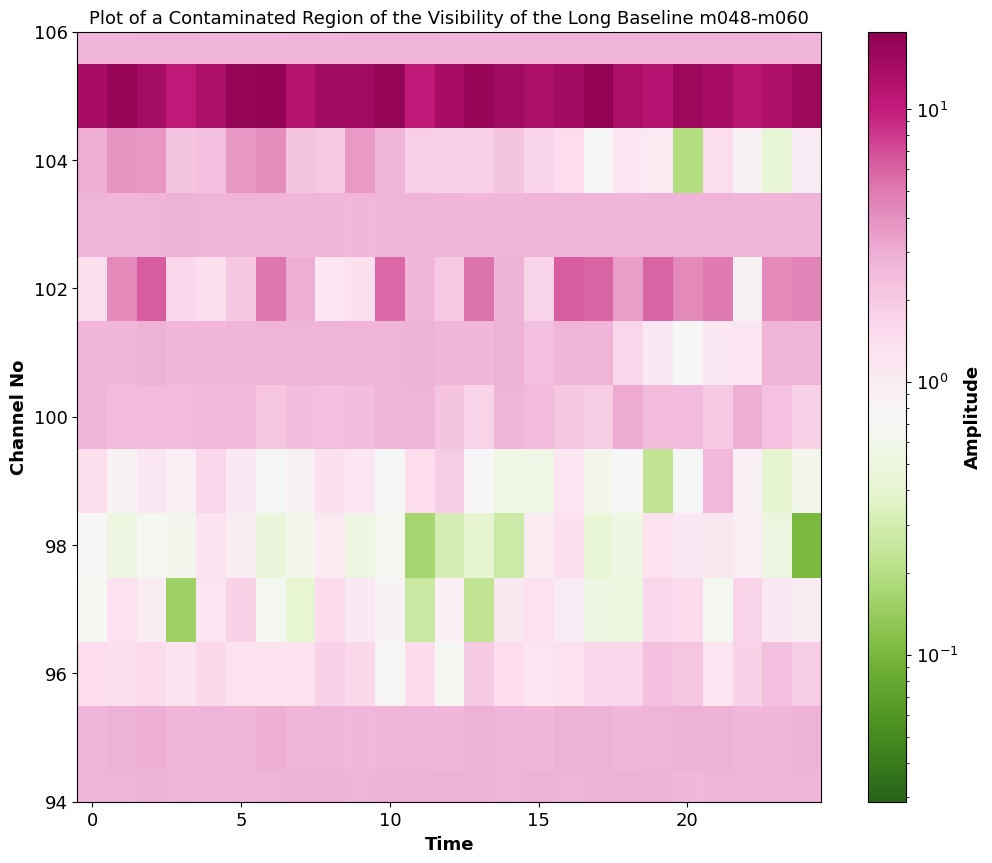

In [195]:
# Plotting the short baseline visibility - zoomed in on RFI region

plt.imshow(np.abs(vis_long[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )

plt.ylim(94,106)

plt.colorbar(label='Amplitude')

plt.xlabel('Time')
plt.ylabel('Channel No')

plt.title(f"Plot of a Contaminated Region of the Visibility of the Long Baseline m048-m060")

Text(0.5, 1.0, 'Plot of a Contaminated Region of the Visibility of the Long Baseline m048-m060')

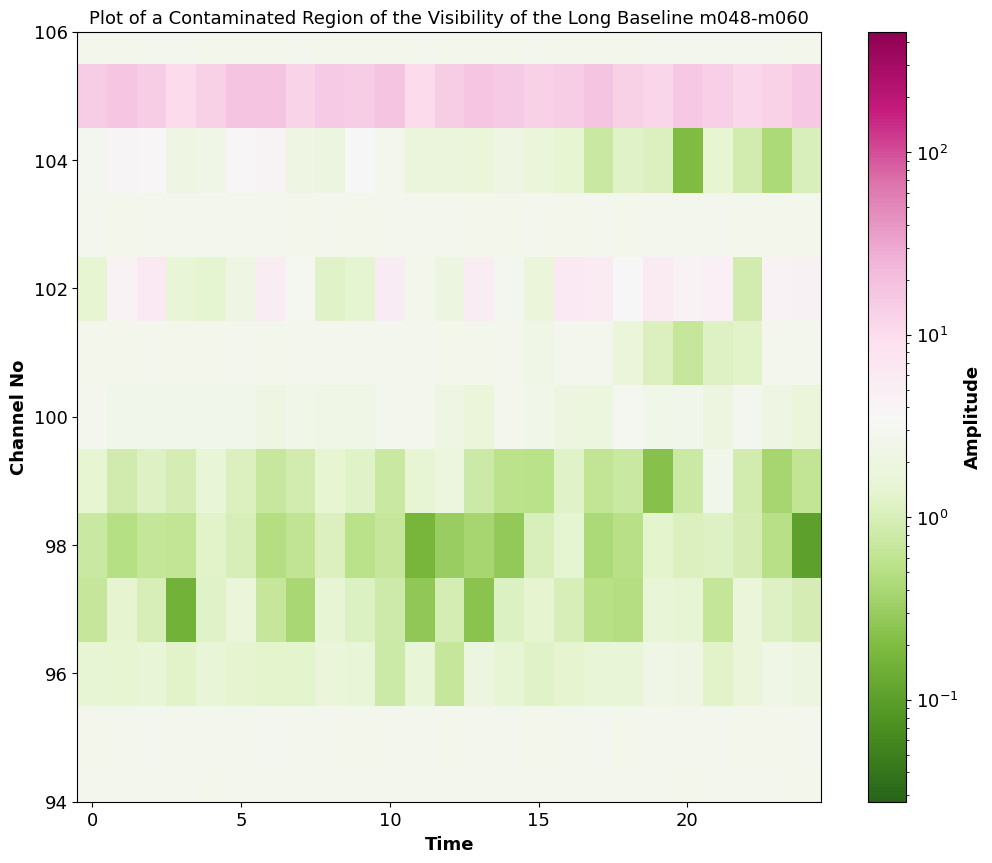

In [196]:
# Plotting the short baseline visibility - zoomed in on RFI region with the same colour scale as the short baseline

plt.imshow(np.abs(vis_long[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PiYG_r',
           norm = colors.LogNorm()
           )

plt.ylim(94,106)

plt.clim(vlims[0], vlims[1])
plt.colorbar(label='Amplitude')

plt.xlabel('Time')
plt.ylabel('Channel No')

plt.title(f"Plot of a Contaminated Region of the Visibility of the Long Baseline m048-m060")

<ipython-input-197-83c4c27282fb>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_xticks(np.arange(frequencies[0]/1e6,frequencies[-1]/1e6, step=100))


Text(0.5, 0.98, 'Plot of the Single Time-Slice Visibility of the Baseline m000-m001')

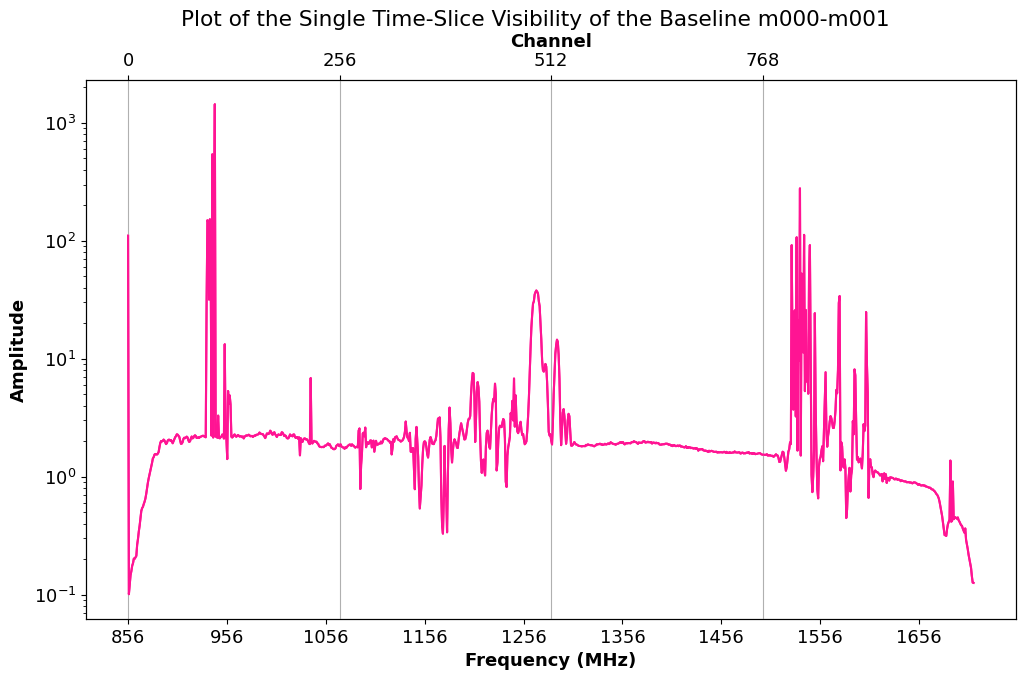

In [197]:
# Question 6 - Extracting the HPBW of the RFI and 940 MHz

# Plotting the entire time slice of the 'default' baseline

frequencies = frequencies.T
absdata = np.abs(vis[10,:,0]).compute()

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(frequencies/1.e6, absdata, color='deeppink')
ax1.set_xticks(np.arange(frequencies[0]/1e6,frequencies[-1]/1e6, step=100))
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Amplitude')

ax2.plot(absdata,color='deeppink')
ax2.set_xticks(np.arange(0,absdata.shape[0], step=256))
ax2.set_xlabel('Channel')
plt.grid()

plt.yscale('log')
plt.suptitle(f"Plot of the Single Time-Slice Visibility of the Baseline m000-m001")

<ipython-input-198-8fb3aaedb963>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx], 15)


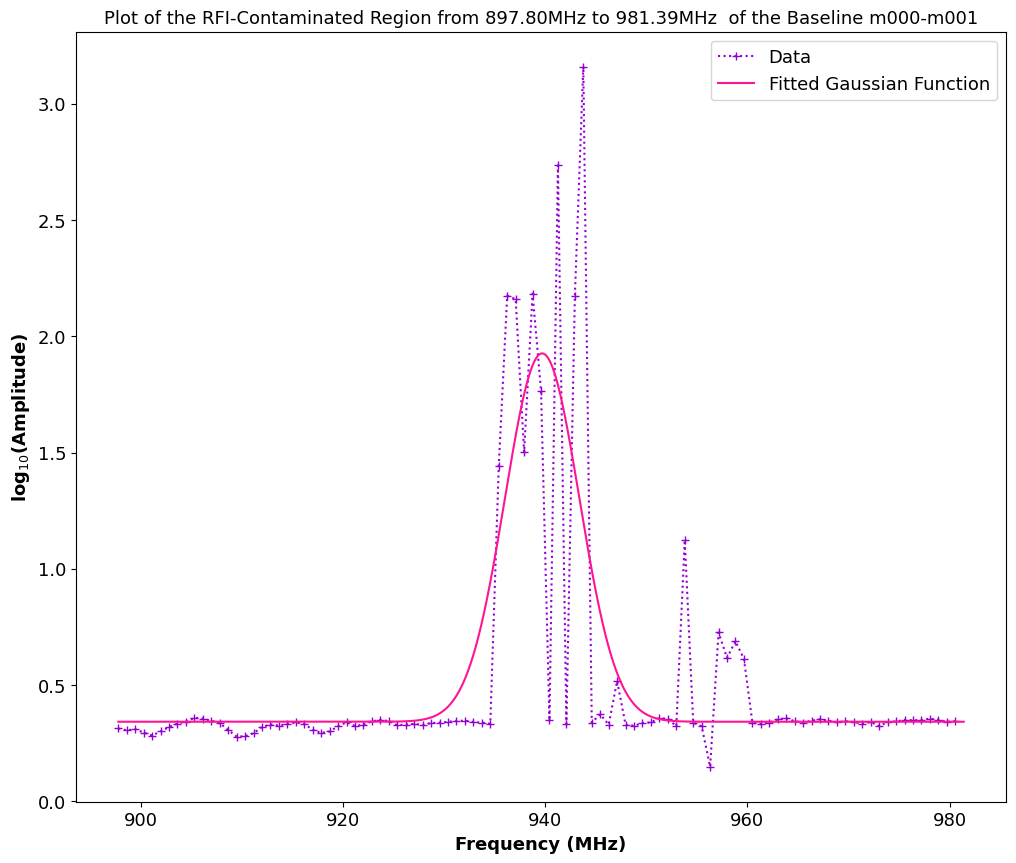

In [198]:
# Fitting a Gaussian Function to the RFI at 940 MHz

def gaussian(x, a, x0, sigma, c):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c

# Selecting the region around the RFI

ini_idx = 50
fin_idx = 150

x = np.ravel(frequencies[ini_idx:fin_idx])
y = np.log10(absdata[ini_idx:fin_idx])

# Initial Guesses

mean = 940*1e6
sigma = 20*1e6
amp = np.max(y)
dc = np.nanmean(np.log10(absdata[550:750]))-1

# Fitting the data

popt, pcov = curve_fit(gaussian, x, y, p0=[amp, mean, sigma, dc])

plt.plot(x/1e6, y, '+:', label='Data', color='darkviolet')
x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx], 15)
plt.plot(x_new/1e6, gaussian(x_new, *popt), color='deeppink', label='Fitted Gaussian Function')
plt.legend()

plt.ylabel(r'log$_{10}$(Amplitude)')
plt.xlabel('Frequency (MHz)')
plt.title(f"Plot of the RFI-Contaminated Region from {channel_to_mhz(50):.2f}MHz to {channel_to_mhz(150):.2f}MHz  of the Baseline m000-m001")
plt.show()

In [199]:
# Calculating the HBPW

fitted_params = [*popt]

print (f"HPBW (MHz) =  {(2.*np.sqrt(2.*np.log(2.))*fitted_params[2])/1.e6}")

HPBW (MHz) =  8.669620825259853


In [200]:
# Question 7  - Finding the Number of Channels Affected

print(f"Number of channels affected: {int(((2.*np.sqrt(2.*np.log(2.))*fitted_params[2]))/(channel_width))}")

Number of channels affected: 10


In [201]:
# Question 8 - Finding the Redhsift of a Galaxy that would have its HI (1420 MHz) Signal at 940MHz

def redshift(femit, fobs):
  return (femit - fobs)/fobs

print(f"The redshift of a galaxy with HI at 940 MHz is: {redshift(1420, 940)}")

The redshift of a galaxy with HI at 940 MHz is: 0.5106382978723404


In [202]:
# Question 9 - Effects of 153 MHz RFI

print("The fundamental frequency is 153 MHz")

harmonics = [153]

for i in range(1, 11):
  harmonic = (i+1)*153
  harmonics.append(harmonic)
  if i+1 == 2:
    print(f"The {i+1}nd harmonic is at {harmonic} MHz")
  elif i+1 == 3:
    print(f"The {i+1}rd harmonic is at {harmonic} MHz")
  else:
    print(f"The {i+1}th harmonic is at {harmonic} MHz")

The fundamental frequency is 153 MHz
The 2nd harmonic is at 306 MHz
The 3rd harmonic is at 459 MHz
The 4th harmonic is at 612 MHz
The 5th harmonic is at 765 MHz
The 6th harmonic is at 918 MHz
The 7th harmonic is at 1071 MHz
The 8th harmonic is at 1224 MHz
The 9th harmonic is at 1377 MHz
The 10th harmonic is at 1530 MHz
The 11th harmonic is at 1683 MHz


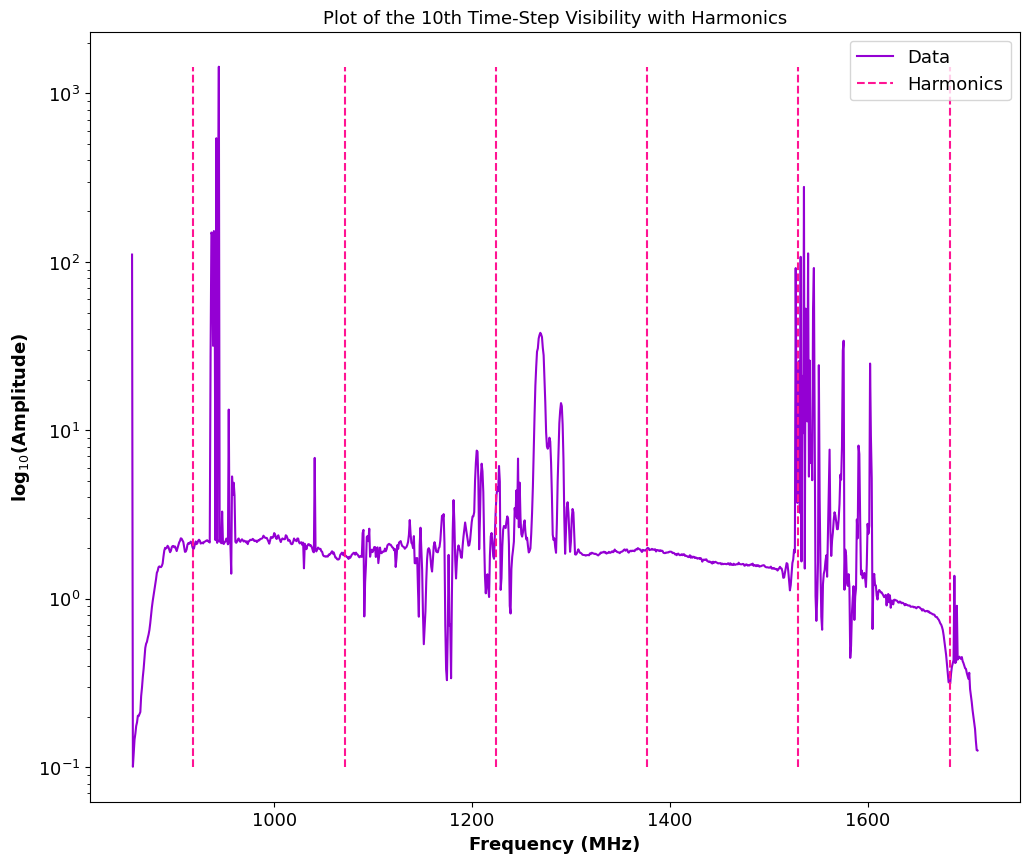

In [203]:
# Plotting the harmonics on the visibility

plt.plot(frequencies/1.e6, absdata, color='darkviolet', label='Data')
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Amplitude')

plt.vlines(harmonics[5:11], absdata.min(), absdata.max(), color='deeppink', linestyle='--', label='Harmonics')

#plt.legend()

plt.yscale('log')
plt.title(f"Plot of the 10th Time-Step Visibility with Harmonics")
plt.ylabel(r'log$_{10}$(Amplitude)')
plt.xlabel('Frequency (MHz)')
plt.legend()

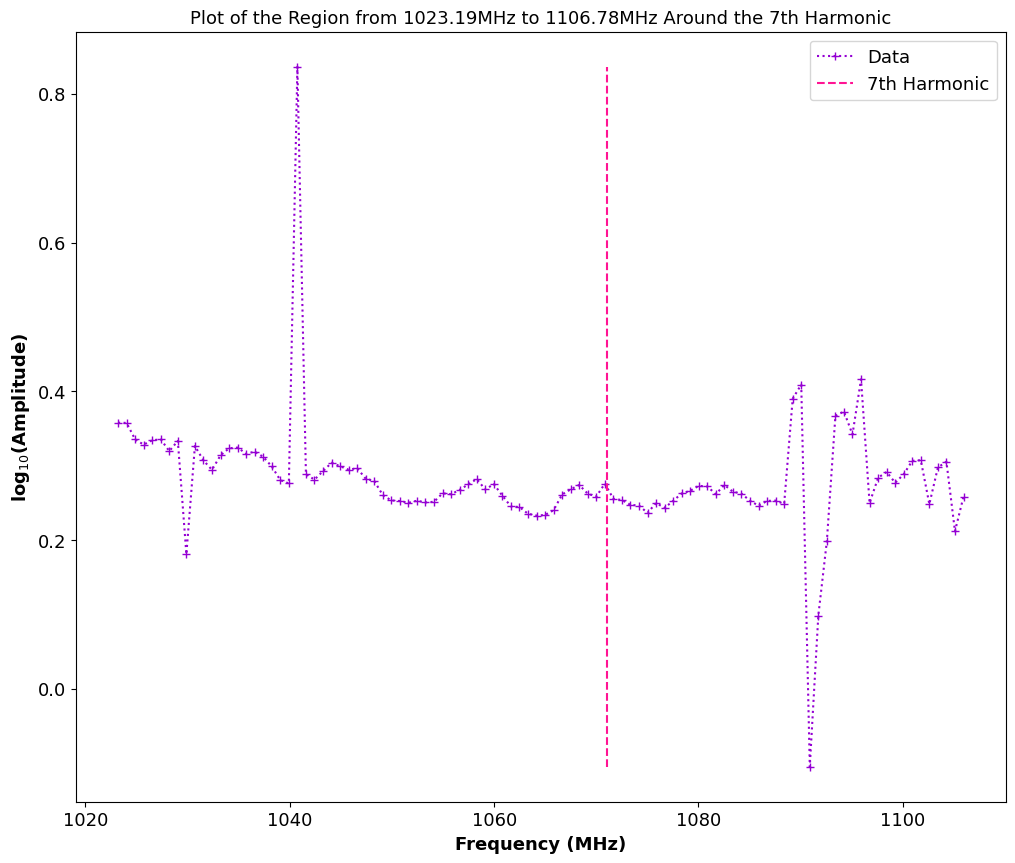

In [204]:
# Example Clean Region Around 7th harmonic

ini_idx = 200
fin_idx = 300

x = np.ravel(frequencies[ini_idx:fin_idx])
y = np.log10(absdata[ini_idx:fin_idx])

plt.plot(x/1e6, y, '+:', label='Data', color='darkviolet')
plt.vlines(1071, y.min(), y.max(), color='deeppink', label='7th Harmonic', linestyle='--')

plt.ylabel(r'log$_{10}$(Amplitude)')
plt.xlabel('Frequency (MHz)')
plt.title(f"Plot of the Region from {channel_to_mhz(200):.2f}MHz to {channel_to_mhz(300):.2f}MHz Around the 7th Harmonic")
plt.legend()
plt.show()

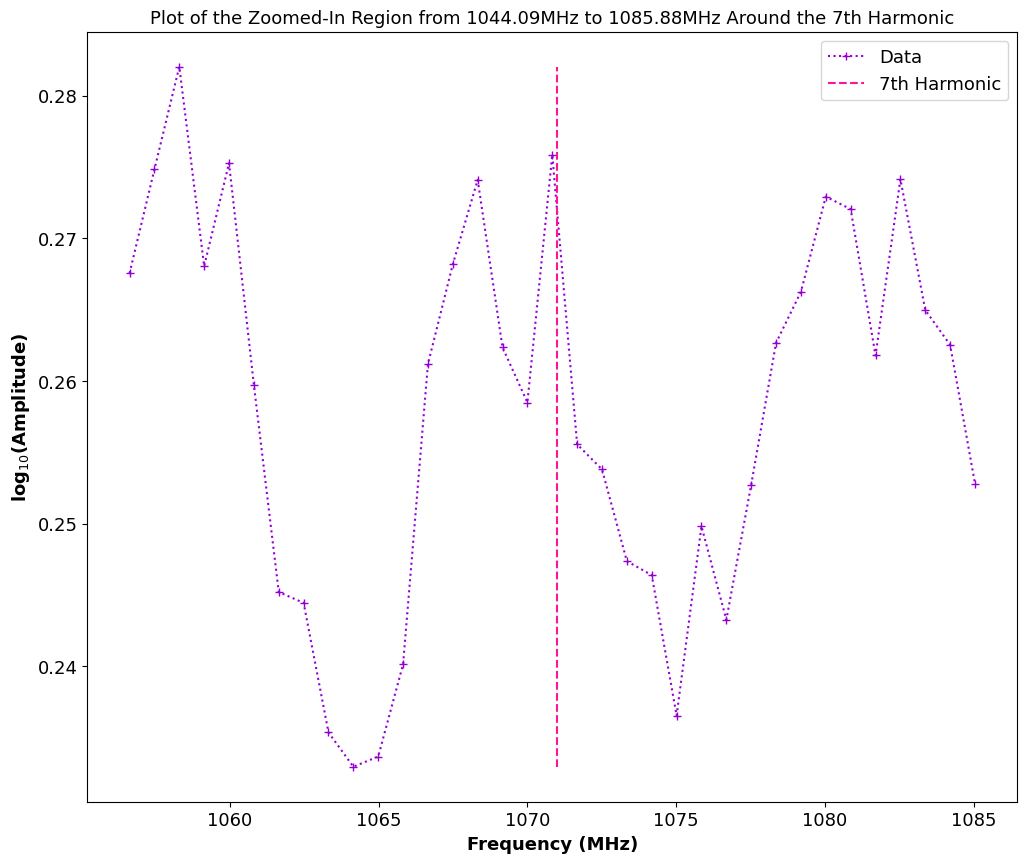

In [205]:
# Example Clean Region Around 7th harmonic - Zoomed In

ini_idx = 240
fin_idx = 275

x = np.ravel(frequencies[ini_idx:fin_idx])
y = np.log10(absdata[ini_idx:fin_idx])

plt.plot(x/1e6, y, '+:', label='Data', color='darkviolet')
plt.vlines(1071, y.min(), y.max(), color='deeppink', label='7th Harmonic', linestyle='--')

plt.ylabel(r'log$_{10}$(Amplitude)')
plt.xlabel('Frequency (MHz)')
plt.title(f"Plot of the Zoomed-In Region from {channel_to_mhz(225):.2f}MHz to {channel_to_mhz(275):.2f}MHz Around the 7th Harmonic")
plt.legend()
plt.show()

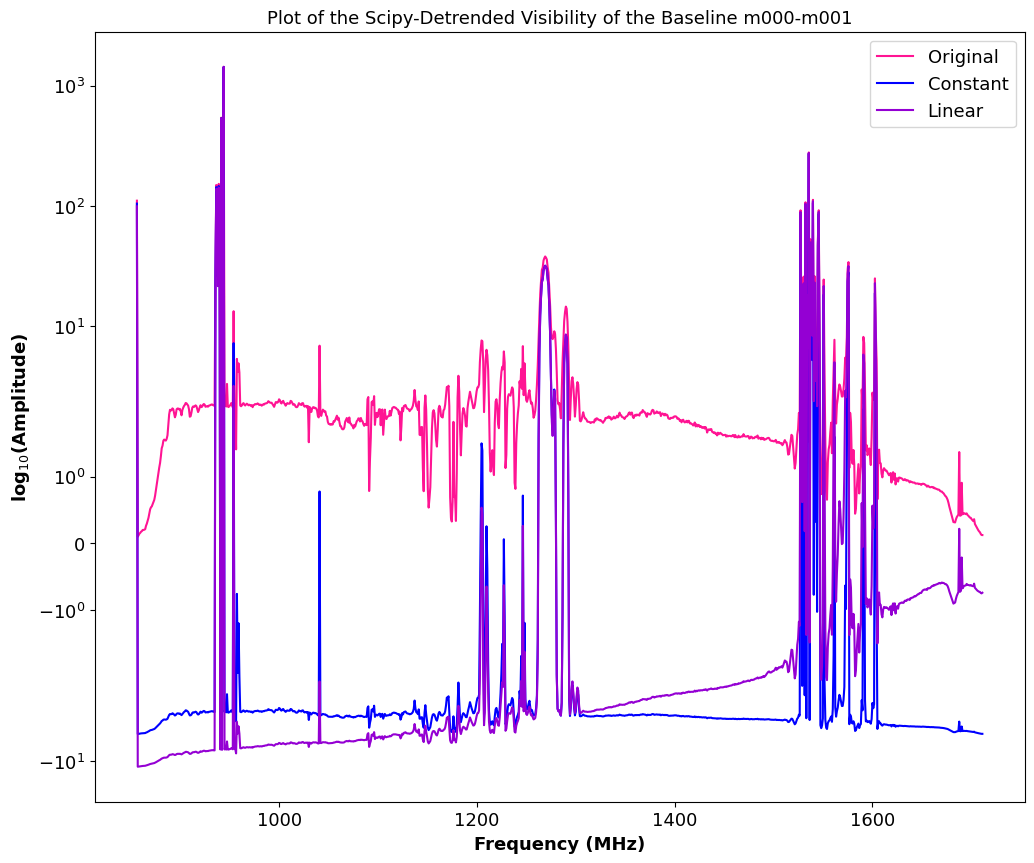

In [206]:
# Question 10 - Detrending the Signal

# Scipy detrending with different methods

detrended_const = detrend(absdata, type='constant')
detrended_linear = detrend(absdata, type='linear')

# Plotting against original

plt.plot(frequencies/1.e6, absdata, color='deeppink', label='Original')
plt.plot(frequencies/1.e6, detrended_const, color='blue', label='Constant')
plt.plot(frequencies/1.e6, detrended_linear, color='darkviolet', label='Linear')

plt.yscale('symlog')
plt.title(f"Plot of the Scipy-Detrended Visibility of the Baseline m000-m001")
plt.ylabel(r'log$_{10}$(Amplitude)')
plt.xlabel('Frequency (MHz)')
plt.legend()

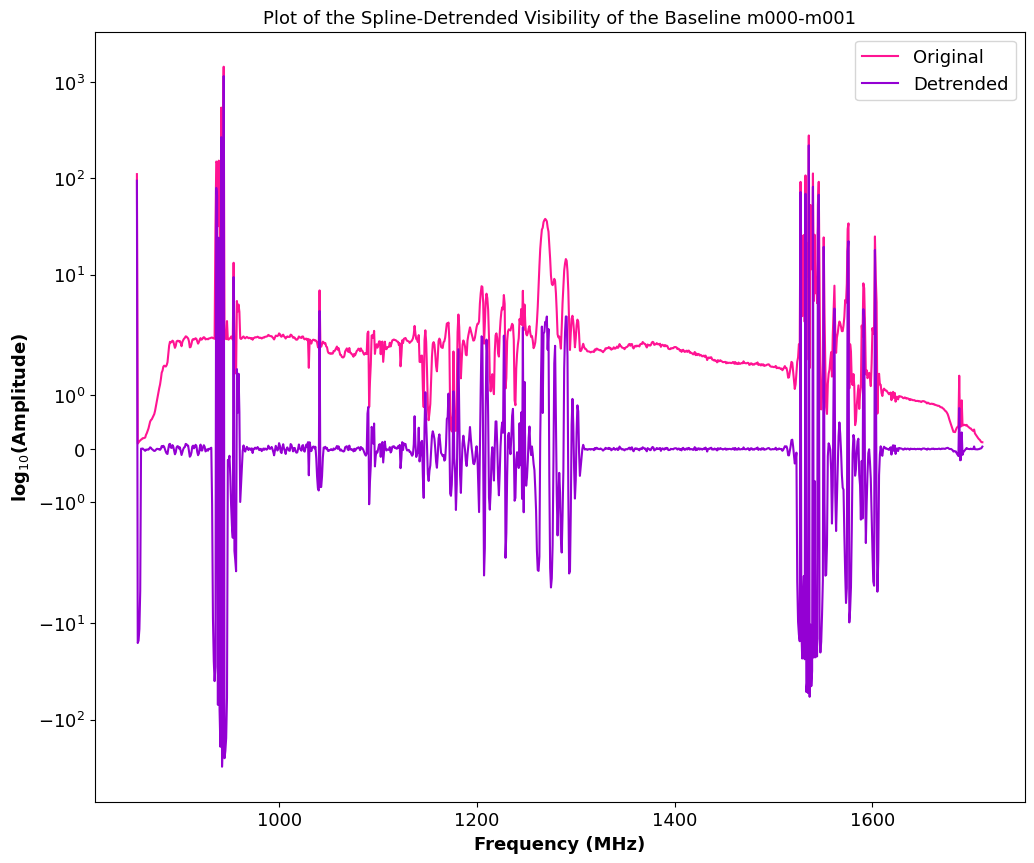

In [207]:
# Method of detrending using "moving average" with a spline-shaped box (to avoid edge distortions) taken from https://dsp.stackexchange.com/questions/84527/detrend-a-signal-with-break-point-but-without-jumps#:~:text=Detrending%20means%20to%20calculate%20a,version%20of%20the%20original%20data.

# Generating the splines

half_splinewidth = 5
spline =  np.zeros((half_splinewidth * 2 + 1), dtype = float)
for n in range(half_splinewidth + 1):
    x = (n / half_splinewidth) ** 2 * math.pi
    w = (math.cos(x) + 1) / 2
    spline[half_splinewidth + n] = w
    spline[half_splinewidth - n] = w

# Normalising the splines such that the area under the curve = 1
integral = np.trapz(spline)
spline /= integral

# Convolving the splines with the data

trend = convolve(absdata, spline, mode='same')

# Subtracting the trend

detrended = absdata - trend

# Plotting with original data

plt.plot(frequencies/1.e6, absdata, color='deeppink', label='Original')
plt.plot(frequencies/1.e6, detrended, color='darkviolet', label='Detrended')

plt.yscale('symlog')
plt.title(f"Plot of the Spline-Detrended Visibility of the Baseline m000-m001")
plt.ylabel(r'log$_{10}$(Amplitude)')
plt.xlabel('Frequency (MHz)')
plt.legend()

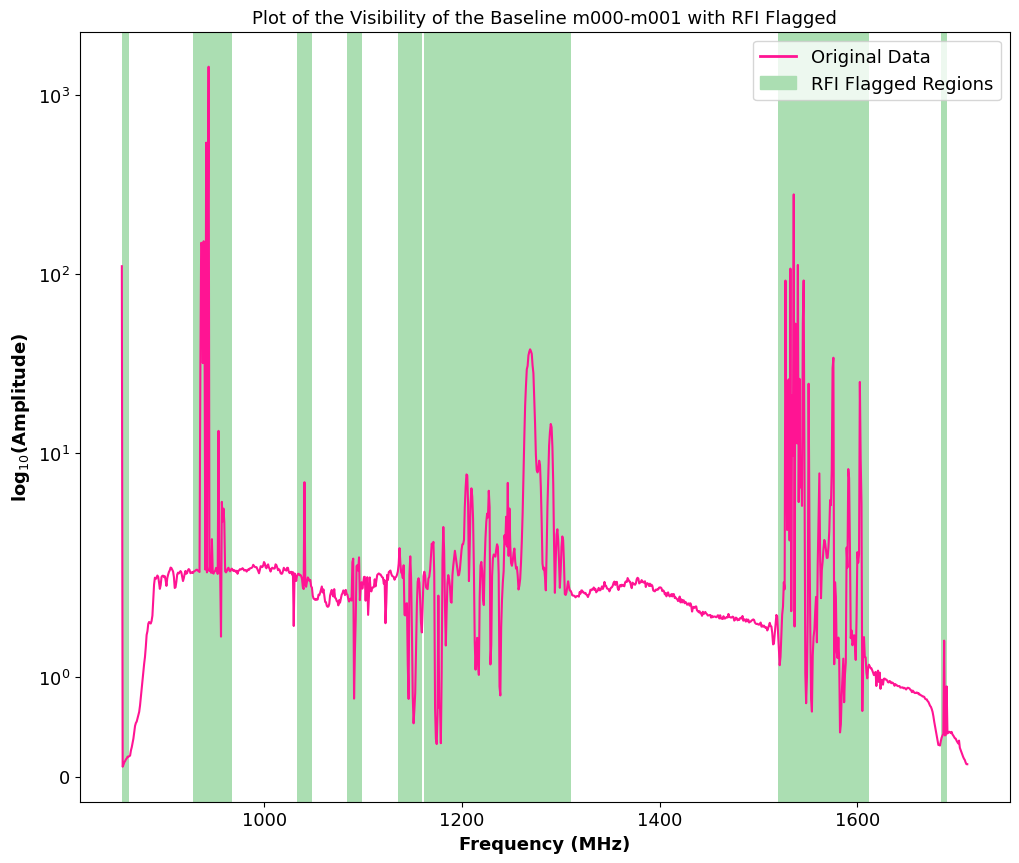

In [208]:
# Question 11 - Filtering for RFI

# Choosing window sizes - 1 small and 1 large

num_points1 = 5
num_points2 = 10

flagged_regions_start = []
flagged_regions_end = []

# Looping over data and calculating standard deviations in each window

for i in range(0, len(absdata)- num_points1 +1, 1):
    window = absdata[i:i + num_points1]
    std_dev = np.std(window)
    if std_dev >= 0.35:                                                           # Value chosen based on one found for clean region
        flagged_regions_start.append(frequencies[i][0]/1e6)                       # Storing the ferquency bounds of the windows
        flagged_regions_end.append(frequencies[i + num_points1 -1][0]/1e6)

for i in range(0, len(absdata)- num_points2 +1, 1):
    window = absdata[i:i + num_points2]
    std_dev = np.std(window)
    if std_dev >= 0.35:
        flagged_regions_start.append(frequencies[i][0]/1e6)
        flagged_regions_end.append(frequencies[i + num_points2 -1][0]/1e6)

# Plotting the original data and highlighting flagged regions

plt.plot(frequencies/1e6, absdata, color='deeppink')
for i in range(len(flagged_regions_start)):
  plt.axvspan(xmin=flagged_regions_start[i], xmax=flagged_regions_end[i], facecolor='#abdeb2')

plt.yscale('symlog')
plt.title(f"Plot of the Visibility of the Baseline m000-m001 with RFI Flagged")
plt.ylabel(r'log$_{10}$(Amplitude)')
plt.xlabel('Frequency (MHz)')

# Custom legend

legend_elements = [
    Line2D([0], [0], color='deeppink', lw=2, label='Original Data'),
    Patch(facecolor='#abdeb2', edgecolor='#abdeb2', label='RFI Flagged Regions')
]

plt.legend(handles=legend_elements, loc='upper right')

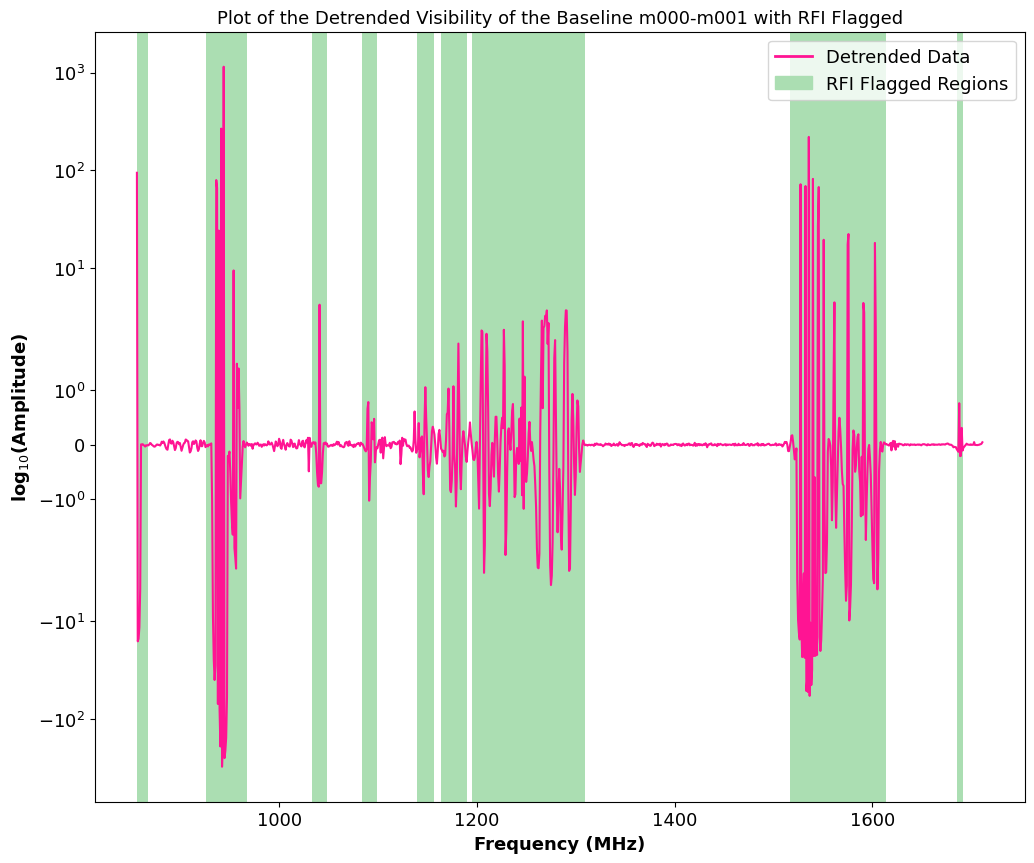

In [209]:
# Same as the above, but with the detrended data

num_points1 = 5
num_points2 = 10
flagged_regions_start = []
flagged_regions_end = []

for i in range(0, len(detrended)- num_points1 +1, 1):
    window = detrended[i:i + num_points1]
    std_dev = np.std(window)
    if std_dev >= 0.35:
        flagged_regions_start.append(frequencies[i][0]/1e6)
        flagged_regions_end.append(frequencies[i + num_points1 -1][0]/1e6)

for i in range(0, len(detrended)- num_points2 +1, 1):
    window = detrended[i:i + num_points2]
    std_dev = np.std(window)
    if std_dev >= 0.35:
        flagged_regions_start.append(frequencies[i][0]/1e6)
        flagged_regions_end.append(frequencies[i + num_points2 -1][0]/1e6)

# Plotting the detrended data and highlighting flagged regions

plt.plot(frequencies/1e6, detrended, color='deeppink')
for i in range(len(flagged_regions_start)):
  plt.axvspan(xmin=flagged_regions_start[i], xmax=flagged_regions_end[i], facecolor='#abdeb2')

plt.yscale('symlog')
plt.title(f"Plot of the Detrended Visibility of the Baseline m000-m001 with RFI Flagged")
plt.ylabel(r'log$_{10}$(Amplitude)')
plt.xlabel('Frequency (MHz)')

legend_elements = [
    Line2D([0], [0], color='deeppink', lw=2, label='Detrended Data'),
    Patch(facecolor='#abdeb2', edgecolor='#abdeb2', label='RFI Flagged Regions')
]

plt.legend(handles=legend_elements, loc='upper right')

In [211]:
# Question 12 - Finding the Satellites

from astropy import units as u

t = start
meerkat = EarthLocation.of_site('meerkat')

# RA and Dec of PKS 1934-63 from https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=PKS1934-63&submit=SIMBAD+search

ra = '19 39 25.0245304992'
dec = '-63 42 45.640373400'
sky_coord = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg), frame='icrs')
alt_az = sky_coord.transform_to(AltAz(obstime=t, location=meerkat))
pks_alt = alt_az.alt.deg
pks_az = alt_az.az.deg

# Size of search area
radius = 45

satellites = []
TLE1 = []
TLE2 = []
nearby_sats = []
ALT = []
AZ = []

# Looping through satellite TLEs

with open(tlefile, 'r') as file:
    for i, line in enumerate(file):
        line = line.strip()
        if i % 3 == 0:
            satellites.append(line)
        elif i % 3 == 1:
            TLE1.append(line)
        else:
            TLE2.append(line)

# Converting TLE to Alt and Az above Meerkat at the start of the observation

for i in range(len(satellites)):                  # Satellite TLE conversion code taken from https://docs.astropy.org/en/stable/coordinates/satellites.html
  satellite = Satrec.twoline2rv(TLE1[i], TLE2[i])
  error_code, teme_p, teme_v = satellite.sgp4(t.jd1, t.jd2)
  if error_code != 0:
    raise RuntimeError(SGP4_ERRORS[error_code])
  teme_p = CartesianRepresentation(teme_p*u.km)
  teme_v = CartesianDifferential(teme_v*u.km/u.s)
  teme = TEME(teme_p.with_differentials(teme_v), obstime=t)

  itrs_geo = teme.transform_to(ITRS(obstime=t))
  topo_itrs_repr = itrs_geo.cartesian.without_differentials() - meerkat.get_itrs(t).cartesian
  itrs_topo = ITRS(topo_itrs_repr, obstime = t, location=meerkat)

  aa = itrs_topo.transform_to(AltAz(obstime=t, location=meerkat))
  alt = aa.alt.deg
  az = aa.az.deg

  # Filtering for only satellites within search region

  if alt >= (pks_alt - radius) and alt <= (pks_alt + radius):
    if az >= (pks_az - radius) and az <= (pks_az + radius):
      ALT.append(alt)
      AZ.append(az)
      nearby_sats.append(satellites[i])

separations = []

# Calculating separations from PKS 1934-63

for i in range(len(ALT)):
  sat_coord = SkyCoord(az=AZ[i]*u.deg, alt=ALT[i]*u.deg, frame='altaz', obstime=t, location=meerkat)  # Getting into the right astropy units
  separations.append(sky_coord.separation(sat_coord).value)
  print(f"The satellite {nearby_sats[i]} has an angular separation of {separations[i]} degrees")

The satellite BEIDOU-3 M16 has an angular separation of 7.8612247444320795 degrees
The satellite BEIDOU-3 M16 has an angular separation of 7.852406931234581 degrees
The satellite BEIDOU-3 M16 has an angular separation of 7.852032636400375 degrees
The satellite BEIDOU-3 M16 has an angular separation of 7.856455090289886 degrees
The satellite BEIDOU-3 M16 has an angular separation of 7.852312828328044 degrees
The satellite BEIDOU-3S M1S has an angular separation of 30.825843387045683 degrees
The satellite BEIDOU-3S M1S has an angular separation of 30.826368064252154 degrees
The satellite BEIDOU-3S M1S has an angular separation of 30.826567205292893 degrees
The satellite BEIDOU-3S M1S has an angular separation of 30.827543814665102 degrees
The satellite BEIDOU-3S M1S has an angular separation of 30.827735418700218 degrees
The satellite COSMOS 2529 [GLONASS-M] has an angular separation of 43.98141201082973 degrees
The satellite COSMOS 2529 [GLONASS-M] has an angular separation of 43.981061